# Analysis of Tailored Forming Processes
This Jupyter notebook contains different analyses of scholarly knowledge from scientific publications on the topic of *Tailored Forming Processes for Manufacturing Components* from the research field *Mechanical Process Engineering*. These analyses are based on domain-specific questions on the described scholarly knowledge raised by domain experts in this research area. While the individual questions are presented below for overview, their details are explained in the respective section of this Jupyter notebook.

Questions:
1. How does the tailored forming process affect the hardness in the surface layer of the manufactured component?
2. s

* Welche Lebensdauern lassen sich mit hybriden wälzbelasteten Bauteilen erzielen in Abhängigkeit von der gewählten Materialkombination?
* Welche Härten lassen sich in der Randschicht/Beschichtung erzielen und wie beeinflusst die Prozesskette den Härteverlauf?
* Bei welche Materialkombinationen treten bei der Umformung Defekte auf?

For the description of the scholarly knowledge from such publications in this research field, we developed a template to consistently describe a tailored forming process for manufacturing components. This description includes the entire process with its steps, source materials, and resulting components with its qualitites. The template allows to describe each step of a process in terms of its order in the process, its input, applied manufacturing method, and output with the investigated qualities, their associated measurement methods and measurements results.

## Loading data from ORKG SPAQRL endpoint
First, the data from the publications on *Tailored Forming Processes for Manufacturing Components* is loaded from the Open Research Knowledge Graph ([ORKG](https://www.orkg.org/orkg/)).

In [4]:
import sparql_dataframe

ENDPOINT_URL = "https://www.orkg.org/orkg/triplestore"

PREFIXES =  """
            PREFIX orkgr: <http://orkg.org/orkg/resource/>
            PREFIX orkgc: <http://orkg.org/orkg/class/>
            PREFIX orkgp: <http://orkg.org/orkg/predicate/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            """

query = """
        SELECT ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality ?num_value ?textual_value ?avg_range (xsd:float(?lower_num_value) AS ?min_value) (xsd:float(?upper_num_value) AS ?max_value) ?unit
                WHERE {
                        #Get all steps and their resulting component (output) and measurement methods (method)
                        ?contrib_url a orkgc:C21027.
                        ?contrib_url orkgp:P7108 ?process_plan;
                                rdfs:label ?contrib.
                        ?process_plan orkgp:P44026 ?step_n.
                        ?step_n orkgp:P7111 ?step_n_name;
                                orkgp:P44025* ?step_n_plus_1;
                                orkgp:P44012 ?method_n;
                                orkgp:HAS_METHOD ?manufacturing_method_n;
                                orkgp:P30012 ?output_n.
                        ?step_n_plus_1 orkgp:P7111 ?step_n_plus_1_name;
                                        orkgp:P44012 ?method_n_plus_1;
                                        orkgp:HAS_METHOD ?manufacturing_method_n_plus_1;
                                        orkgp:P30012 ?output_n_plus_1.
                        BIND(IF(?step_n_plus_1 = ?step_n, ?method_n, ?method_n_plus_1) AS ?method_resrc)
                        BIND(IF(?step_n_plus_1 = ?step_n, ?manufacturing_method_n, ?manufacturing_method_n_plus_1) AS ?manu_method_resrc)
                        BIND(IF(?step_n_plus_1 = ?step_n, ?output_n, ?output_n_plus_1) AS ?output)
   
                        #Get all qualities from all layers of the resulting component
                        ?output orkgp:P28005 ?layer_resrc;
                                orkgp:P7111 ?component_type.
                        ?component_type rdfs:label ?component.
                        ?layer_resrc orkgp:P3 ?layer_type; #all layers
                                orkgp:P7000 ?material_resrc.
                        ?layer_type rdfs:label ?layer.
                        ?material_resrc orkgp:P7113 ?quality_resrc;
                                orkgp:P42007 ?material_type.
                        ?material_type rdfs:label ?material.
                        ?quality_resrc orkgp:P7111 ?quality_type;
                                orkgp:P44022 ?measurement.
                        ?quality_type rdfs:label ?quality.
                        
                        #Get the manufacturing method for each step
                        ?manu_method_resrc orkgp:P7111 ?manu_method_name.
                        ?manu_method_name rdfs:label ?manufacture_method.
                        
                        #Get the measurement method for each measurement
                        ?method_resrc orkgp:P7111 ?method_name;
                                orkgp:HAS_RESULTS ?measurement.
                        ?method_name rdfs:label ?measure_method.
  
                        # Get the range and unit of the resulting component
                        OPTIONAL{?measurement orkgp:P44010 ?range.
                                ?range orkgp:P43248 ?lower_value;
                                        orkgp:P43247 ?upper_value.
                                ?upper_value orkgp:P42000 ?range_unit.
                                ?lower_value orkgp:P44011 ?lower_num_value.
                                ?upper_value orkgp:P44011 ?upper_num_value.}
                        
                        # Get the measurement value and unit of the resulting component
                        OPTIONAL{?measurement orkgp:HAS_VALUE ?value.
                                ?value orkgp:P44011 ?measurement_value.
                                BIND(IF(REGEX(?measurement_value, "^\\\d*\\\.?\\\d*$", "i"), xsd:float(?measurement_value), "") AS ?num_value)
                                BIND(IF(REGEX(?measurement_value, "^\\\d*\\\.?\\\d*$", "i"), "", ?measurement_value) AS ?textual_value)
                        OPTIONAL{?value orkgp:P42000 ?value_unit.}}
                        
                        #If no value is reported, calculate the average value based on the reported range
                        BIND(IF (BOUND(?value), "", (((xsd:float(?lower_num_value) + xsd:float(?upper_num_value)) / 2) AS ?avg_value) ) AS ?avg_range).
                        #Get the unit either from the value or the range
                        BIND(IF (BOUND(?value), ?value_unit, ?range_unit) AS ?unit_resrc).
                        OPTIONAL {?unit_resrc rdfs:label ?unit.}
                        
                        #Get the number of the step in the process plan
                        ?step_n_plus_1_name rdfs:label ?step_name.
                        BIND(STR(?step_name) AS ?step)
                        VALUES(?step ?step_number){("Deposition welding" 1) ("Hot forming" 2) ("Cooling" 3) ("Heat treatment" 4) ("Machining" 5)}
                }
                GROUP BY ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality
                ORDER BY ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality
        """
tf_data = sparql_dataframe.get(ENDPOINT_URL, PREFIXES+query)
tf_data.head()

,contrib_url,contrib,component,step_number,step_name,manufacture_method,layer,material,measure_method,quality,num_value,textual_value,avg_range,min_value,max_value,unit
0,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,Hardness profile,Hardness,NaN,NaN,150.0,100.0,200.0,HV0.5
1,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,Micrograph,Microstructure,NaN,ferritic-pearlitic,NaN,NaN,NaN,NaN
2,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Hardness profile,Hardness,NaN,NaN,400.0,350.0,450.0,HV0.5
3,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Micrograph,Microstructure,NaN,pearlitic,NaN,NaN,NaN,NaN
4,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Nano-scratch test,Indentation depth,10.6,NaN,NaN,NaN,NaN,Nanometer


## 1. Question: How does the tailored forming process affect the hardness in the surface layer of the manufactured component?
In Tailored Forming, the hardness in the surface layer of a manufactured component is decisive for its use since this layer is subjected to high stresses during use. Based on this background, the question arises as to how the individual process steps affect the hardness in the surface layer of a component.

### Gathering the necessary data to answer the question
The following is a compilation of the necessary data from the entire data set on *Tailored Forming Processes for Manufacturing Components* to answer the question.

In [34]:
tf_data['calc_value'] = tf_data['num_value'].fillna(tf_data['avg_range'])
hardness_data = tf_data.query('quality == "Hardness" and layer == "Cladding layer"')[['contrib_url','step_number', 'step_name', 'calc_value', 'unit']]
grouped_data = hardness_data.groupby('contrib_url')
steps = tf_data.sort_values('step_number')[['step_number', 'step_name']].drop_duplicates()

### Visualization of the data

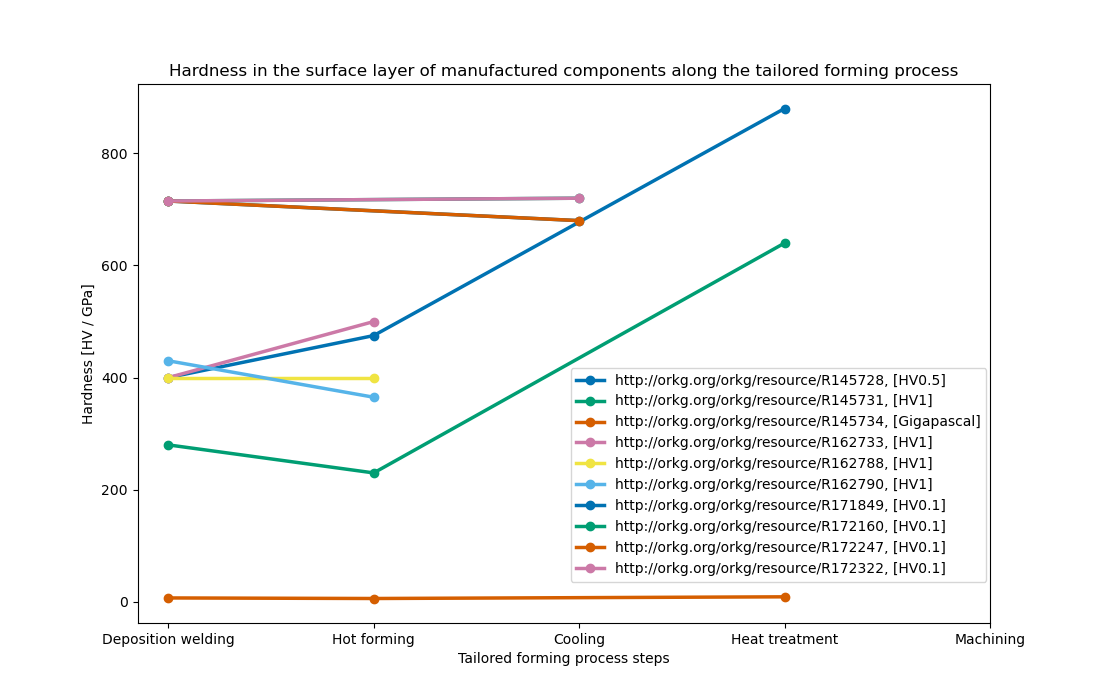

In [35]:
%matplotlib widget
import matplotlib.pyplot as plt

#fig, ax = plt.subplots(grouped_data.ngroups)
fig, ax = plt.subplots()
plt.style.use('seaborn-colorblind')

fig.set_size_inches(11, 7)

for name, group in grouped_data:
    ax.plot(group['step_number'], group['calc_value'], marker='o', linewidth=2.5, label=name+', ['+group['unit'][:1].item()+']')

ax.set_xticks(steps['step_number'])
ax.set_xticklabels(steps['step_name'])

ax.set_title('Hardness in the surface layer of manufactured components along the tailored forming process')
ax.set_xlabel('Tailored forming process steps')
ax.set_ylabel('Hardness [HV / GPa]')
legend = ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.275))

plt.ion()
plt.show()